In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import gc

import datetime
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math

import textwrap
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import pydotplus
from IPython.display import Image
from graphviz import Digraph
from sklearn import tree


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)


In [2]:
df = pd.read_csv("../data/viewing_rating.csv", encoding='cp932')

In [3]:
# time型に
df.start_at=pd.to_datetime(df.start_at)
# averageの％を削除
df["average"] =  df["average"].apply(lambda x : float(x[:-1]) )


In [4]:
df["start_at_year"] = df["start_at"].dt.year
df["start_at_month"] = df["start_at"].dt.month

In [5]:
df["drama_key"] = df.start_at.dt.strftime("%y")+df.start_at.dt.strftime("%m")+"_"+df.TV_station+"_"+df.time_table

In [6]:
import json

f = open("../data/drama_info0115.json", 'r')
print(f)
drama_info_json = json.load(f)

<_io.TextIOWrapper name='../data/drama_info0115.json' mode='r' encoding='UTF-8'>


In [7]:
# def addDramaInfo (drama_title) 
#     main_actor_only_json[drama_title]
    


In [8]:
print (textwrap.shorten(str(drama_info_json), 1000))

{'1910_CX_月21': {'main_actor1': 'ディーン・フジオカ', 'main_actor2': '岩田剛典', 'original_work': 'アーサー・コナン・ドイル「シャーロック・ホームズ」'}, '1910_CX_火22': {'main_actor1': '阿部寛', 'main_actor2': '吉田羊', 'original_work': ''}, '1910_TBS_火22': {'main_actor1': '波瑠', 'main_actor2': '中川大志', 'original_work': 'いくえみ綾「G線上のあなたと私」'}, '1910_NTV_水22': {'main_actor1': '高畑充希', 'main_actor2': '橋本愛', 'original_work': ''}, '1910_EX_木21': {'main_actor1': '米倉涼子', 'main_actor2': 'ユースケ・サンタマリア', 'original_work': ''}, '1910_CX_木22': {'main_actor1': '新木優子', 'main_actor2': '高良健吾', 'original_work': '瀧波ユカリ「モトカレマニア」'}, '1910_NTV_木23': {'main_actor1': '本田翼', 'main_actor2': '金子大地', 'original_work': ''}, '1910_TBS_金22': {'main_actor1': '福士蒼汰', 'main_actor2': '菜々緒', 'original_work': 'キリエ「4分間のマリーゴールド」'}, '1910_EX_金23': {'main_actor1': 'オダギリジョー', 'main_actor2': '麻生久美子', 'original_work': ''}, '1910_NTV_土22': {'main_actor1': '生田斗真', 'main_actor2': '安田顕', 'original_work': ''}, '1910_EX_土23': {'main_actor1': '田中圭', 'main_actor2': '吉田鋼太郎', [...]


In [9]:
df["main_actor1"] = ""
df["main_actor2"] = ""
df["original_work"] = ""

In [10]:
for tmp_index in range(len(df)):
    tmp_drama_key = df.iloc[tmp_index]["drama_key"]
    if tmp_drama_key in drama_info_json.keys():
#         print(drama_info_json[tmp_drama_key]["main_actor1"])
        df["main_actor1"][tmp_index] = drama_info_json[tmp_drama_key]["main_actor1"]
        df["main_actor2"][tmp_index] = drama_info_json[tmp_drama_key]["main_actor2"]
        df["original_work"][tmp_index] = drama_info_json[tmp_drama_key]["original_work"]
#         print("yes"+tmp_drama_title)
    else:
        print(tmp_drama_key)

In [11]:
def make_person_key_df (actor_actress):
    actor_actress_list = []
    for column in actor_actress.columns:
        if column == "ranking":
            continue
        actor_actress_list.extend(actor_actress[column].values.tolist())
    print ("元の数"+ str(len(actor_actress_list)))
    # uniqueにする
    actor_actress_list = list(set(actor_actress_list))
    #nan を除去
    actor_actress_list = [actor for actor in actor_actress_list if type(actor) is not float ]
    print ("後の数"+str(len(actor_actress_list)))

    df_pivot = pd.DataFrame( columns=actor_actress_list, index=[str(n) for n in range(2008,2020)])

    #pivot 形式に整形する
    for tmp_name in df_pivot.columns:
        for year in actor_actress.columns:
            if year == "ranking": continue
            if  len(actor_actress[actor_actress[year] == tmp_name].ranking) > 0:
                df_pivot.loc[year][tmp_name] = (actor_actress[actor_actress[year] == tmp_name].ranking).values[0]
    return (df_pivot)
    

In [12]:
df_actress = pd.read_csv("../data/actress_power.csv", encoding='cp932')
df_actress_pivot = make_person_key_df(df_actress)


元の数360
後の数69


In [13]:
df_actor = pd.read_csv("../data/actor_power.csv", encoding='cp932')
df_actor_pivot = make_person_key_df(df_actor)

元の数372
後の数69


In [14]:
df_actress_pivot

,石原さとみ,松嶋菜々子,柴崎コウ,米倉涼子,桐谷美玲,菅野美穂,上野樹里,土屋太鳳,広瀬すず,松たか子,真矢みき,新垣結衣,蒼井優,藤原紀香,宮_あおい,樹木希林,松雪泰子,橋本環奈,優香,戸田恵梨香,武井,永作博美,芦田愛菜,井上真央,松下奈緒,小雪,山口智子,篠原涼子,吉瀬美智子,有村架純,多部未華子,天海祐希,能年玲奈,木村佳乃,深津絵里,江角マキコ,剛力彩芽,常盤貴子,広瀬アリス,波瑠,高畑充希,香里奈,長澤まさみ,北川景子,深田恭子,吉高由里子,吉田羊,上戸彩,石田ゆり子,黒木瞳,黒木メイサ,木村文乃,薬師丸ひろ子,小泉今日子,杏,柴咲コウ,吉永小百合,竹内結子,宮崎あおい,仲間由紀恵,武井咲,堀北真希,榮倉奈々,上戸,松,綾瀬はるか,菜々緒,佐々木希,観月ありさ
2008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010,NaN,3,NaN,19,NaN,5,NaN,NaN,NaN,16,18,9,26,27,10,NaN,NaN,NaN,12,25,NaN,NaN,NaN,28,NaN,30,11,21,NaN,NaN,NaN,1,NaN,NaN,13,NaN,NaN,24,NaN,NaN,NaN,NaN,17,NaN,20,NaN,NaN,4,NaN,14,23,NaN,NaN,NaN,NaN,7,22,8,NaN,2,NaN,15,NaN,NaN,NaN,6,NaN,NaN,29
2011,21,8,NaN,26,NaN,1,18,NaN,NaN,19,20,10,25,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,29,NaN,27,23,NaN,28,12,NaN,NaN,NaN,6,NaN,NaN,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,17,NaN,NaN,3,NaN,30,7,NaN,NaN,16,NaN,4,22,13,NaN,5,NaN,14,NaN,NaN,NaN,2,NaN,NaN,24
2012,23,1,NaN,26,NaN,9,NaN,NaN,NaN,NaN,27,7,NaN,NaN,NaN,NaN,30,NaN,14,NaN,19,NaN,20,13,NaN,NaN,NaN,15,NaN,NaN,NaN,3,NaN,NaN,11,17,NaN,28,NaN,NaN,NaN,25,12,18,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,NaN,10,29,8,16,4,NaN,5,NaN,6,24,2,NaN,NaN,NaN
2013,19,5,NaN,11,NaN,6,NaN,NaN,NaN,NaN,22,9,NaN,NaN,NaN,18,NaN,NaN,12,NaN,NaN,NaN,NaN,20,NaN,NaN,NaN,10,NaN,NaN,NaN,3,NaN,NaN,16,15,30,23,NaN,NaN,NaN,NaN,17,14,13,28,NaN,4,NaN,NaN,NaN,NaN,29,21,NaN,8,27,25,24,7,26,2,NaN,NaN,NaN,1,NaN,NaN,NaN
2014,8,12,NaN,13,NaN,6,NaN,NaN,NaN,23,NaN,5,NaN,NaN,30,24,NaN,NaN,16,NaN,NaN,NaN,NaN,17,29,NaN,NaN,14,NaN,NaN,NaN,9,25,NaN,27,20,NaN,NaN,NaN,NaN,NaN,NaN,22,4,18,NaN,NaN,3,NaN,NaN,NaN,NaN,28,11,15,7,19,NaN,NaN,10,21,2,NaN,NaN,NaN,1,NaN,NaN,26
2015,12,14,NaN,9,29,15,30,NaN,NaN,11,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,19,NaN,NaN,NaN,NaN,20,NaN,NaN,NaN,13,27,NaN,NaN,8,17,NaN,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,4,18,26,NaN,10,NaN,NaN,NaN,NaN,NaN,24,7,6,25,16,NaN,3,23,2,NaN,NaN,NaN,1,NaN,21,NaN
2016,5,21,NaN,20,10,18,NaN,NaN,15,17,NaN,4,NaN,NaN,29,NaN,NaN,NaN,24,NaN,NaN,NaN,NaN,30,NaN,NaN,NaN,14,NaN,3,NaN,7,NaN,NaN,28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22,2,8,NaN,16,12,NaN,NaN,NaN,NaN,NaN,19,11,13,25,26,NaN,9,23,6,NaN,NaN,NaN,1,27,NaN,NaN
2017,3,22,13,18,9,17,NaN,19,11,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28,NaN,NaN,NaN,10,NaN,6,24,8,NaN,NaN,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,4,5,21,NaN,12,20,NaN,NaN,NaN,NaN,27,14,NaN,NaN,29,NaN,7,23,15,26,NaN,NaN,2,NaN,30,NaN


In [15]:
df_actor_namekey = df_actor_pivot.T.rename_axis('actor_actress').reset_index()

In [16]:
df_actress_namekey = df_actress_pivot.T.rename_axis('actor_actress').reset_index()

In [17]:
df_actress_namekey

,actor_actress,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,石原さとみ,NaN,NaN,NaN,21,23,19,8,12,5,3,3,5
1,松嶋菜々子,NaN,NaN,3,8,1,5,12,14,21,22,18,19
2,柴崎コウ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,NaN,NaN
3,米倉涼子,NaN,NaN,19,26,26,11,13,9,20,18,15,12
4,桐谷美玲,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29,10,9,20,23
5,菅野美穂,NaN,NaN,5,1,9,6,6,15,18,17,19,28
6,上野樹里,NaN,NaN,NaN,18,NaN,NaN,NaN,30,NaN,NaN,NaN,NaN
7,土屋太鳳,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,13,24
8,広瀬すず,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,11,10,7
9,松たか子,NaN,NaN,16,19,NaN,NaN,23,11,17,NaN,NaN,NaN


In [18]:
df_merged = pd.merge(df, df_actor_namekey,left_on='main_actor1', right_on='actor_actress', how='left')
#df_merged = pd.merge(df_merged, df_actress_namekey,left_on='main_actor1', right_on='actor_actress', how='right')
#df_merged = pd.merge(df_merged, df_actress_namekey,left_on='main_actor2', right_on='actor_actress', how='right')

In [19]:

df_merged = pd.merge(df_merged, df_actress_namekey,left_on='main_actor1', right_on='actor_actress', how='left'
                     ,suffixes=('_1', '_2'))

In [20]:

df_merged = pd.merge(df_merged, df_actor_namekey,left_on='main_actor2', right_on='actor_actress', how='left'
                     ,suffixes=('_3', '_4') )


In [21]:
df_merged = pd.merge(df_merged, df_actress_namekey,left_on='main_actor2', right_on='actor_actress', how='left'
                    , suffixes=('_3', '_4'),)

In [22]:
# df_merged[["main_actor1","2017","2016","2014"]]
df_merged

,TV_station,time_table,drama_title,Episode1,Episode2,Episode3,Episode4,Episode5,Episode6,Episode7,Episode8,Episode9,Episode10,Episode11,Episode12,Episode13,Episode14,Episode15,average,suii,start_at,start_at_year,start_at_month,drama_key,main_actor1,main_actor2,original_work,actor_actress_1,2008_1,2009_1,2010_1,2011_1,2012_1,2013_1,2014_1,2015_1,2016_1,2017_1,2018_1,2019_1,actor_actress_2,2008_2,2009_2,2010_2,2011_2,2012_2,2013_2,2014_2,2015_2,2016_2,2017_2,2018_2,2019_2,actor_actress_3,2008_3,2009_3,2010_3,2011_3,2012_3,2013_3,2014_3,2015_3,2016_3,2017_3,2018_3,2019_3,actor_actress_4,2008_4,2009_4,2010_4,2011_4,2012_4,2013_4,2014_4,2015_4,2016_4,2017_4,2018_4,2019_4
0,CX,月21,シャーロック,12.8,9.3,9.9,10.6,9.3,8.3,9.9,8.9,9.9,8.8,9.8,-,-,-,-,9.90,5-5-0,2019-10-01,2019,10,1910_CX_月21,ディーン・フジオカ,岩田剛典,アーサー・コナン・ドイル「シャーロック・ホームズ」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CX,火22,まだ結婚できない男,11.5,7.7,10.0,9.5,10,8.9,8.5,8.6,9,9.7,-,-,-,-,-,9.40,5-4-0,2019-10-01,2019,10,1910_CX_火22,阿部寛,吉田羊,,阿部寛,NaN,NaN,11,3,1,1,1,1,1,2,1,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,吉田羊,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,NaN,27
2,TBS,火22,G線上のあなたと私,7.8,8.8,7.3,6.9,6.7,6.7,8.6,7.6,6.5,9.6,-,-,-,-,-,7.65,2003/5/1,2019-10-01,2019,10,1910_TBS_火22,波瑠,中川大志,いくえみ綾「G線上のあなたと私」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,波瑠,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NTV,水22,同期のサクラ,8.1,9.5,9.3,11.5,11.8,11.7,12.2,10.8,10.3,13.7,-,-,-,-,-,10.89,5-4-0,2019-10-01,2019,10,1910_NTV_水22,高畑充希,橋本愛,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,高畑充希,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EX,木21,ドクターX,20.3,19.0,18.1,17.8,15.9,19.3,18.6,17.4,18.2,19.3,-,-,-,-,-,18.48,3-6-0,2019-10-01,2019,10,1910_EX_木21,米倉涼子,ユースケ・サンタマリア,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,米倉涼子,NaN,NaN,19,26,26,11,13,9,20,18,15,12,ユースケ・サンタマリア,NaN,NaN,25,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,TBS,木22,年下の男,11.8,10.7,12.2,11.8,12.6,12.6,13.7,13.5,14.1,14.2,13.3,-,-,-,-,12.77,2005/4/1,2003-01-01,2003,1,0301_TBS_木22,稲森いずみ,高橋克典,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
938,CX,木22,美女か野獣,20.0,17.3,18.6,18.6,17.3,17.5,17,19,19.4,18.9,19.4,-,-,-,-,18.45,2005/4/1,2003-01-01,2003,1,0301_CX_木22,松嶋菜々子,福山雅治,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,松嶋菜々子,NaN,NaN,3,8,1,5,12,14,21,22,18,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
939,TBS,金22,高校教師,14.9,12.2,6.4,10.7,10.6,8.8,10.2,13.5,11.2,8.8,11,-,-,-,-,10.75,4-6-0,2003-01-01,2003,1,0301_TBS_金22,藤木直人,上戸彩,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,上戸彩,NaN,NaN,4,3,NaN,4,3,10,12,12,11,NaN
940,NTV,土21,よい子の味方,13.4,10.2,8.9,10.0,10.1,7.5,11.1,10.7,12,-,-,-,-,-,-,10.43,4-4-0,2003-01-01,2003,1,0301_NTV_土21,櫻井翔,松下由樹,,櫻井翔,NaN,NaN,1,1,3,2,3,3,2,4,3,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
df_merged

,TV_station,time_table,drama_title,Episode1,Episode2,Episode3,Episode4,Episode5,Episode6,Episode7,Episode8,Episode9,Episode10,Episode11,Episode12,Episode13,Episode14,Episode15,average,suii,start_at,start_at_year,start_at_month,drama_key,main_actor1,main_actor2,original_work,actor_actress_1,2008_1,2009_1,2010_1,2011_1,2012_1,2013_1,2014_1,2015_1,2016_1,2017_1,2018_1,2019_1,actor_actress_2,2008_2,2009_2,2010_2,2011_2,2012_2,2013_2,2014_2,2015_2,2016_2,2017_2,2018_2,2019_2,actor_actress_3,2008_3,2009_3,2010_3,2011_3,2012_3,2013_3,2014_3,2015_3,2016_3,2017_3,2018_3,2019_3,actor_actress_4,2008_4,2009_4,2010_4,2011_4,2012_4,2013_4,2014_4,2015_4,2016_4,2017_4,2018_4,2019_4
0,CX,月21,シャーロック,12.8,9.3,9.9,10.6,9.3,8.3,9.9,8.9,9.9,8.8,9.8,-,-,-,-,9.90,5-5-0,2019-10-01,2019,10,1910_CX_月21,ディーン・フジオカ,岩田剛典,アーサー・コナン・ドイル「シャーロック・ホームズ」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CX,火22,まだ結婚できない男,11.5,7.7,10.0,9.5,10,8.9,8.5,8.6,9,9.7,-,-,-,-,-,9.40,5-4-0,2019-10-01,2019,10,1910_CX_火22,阿部寛,吉田羊,,阿部寛,NaN,NaN,11,3,1,1,1,1,1,2,1,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,吉田羊,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,NaN,27
2,TBS,火22,G線上のあなたと私,7.8,8.8,7.3,6.9,6.7,6.7,8.6,7.6,6.5,9.6,-,-,-,-,-,7.65,2003/5/1,2019-10-01,2019,10,1910_TBS_火22,波瑠,中川大志,いくえみ綾「G線上のあなたと私」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,波瑠,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NTV,水22,同期のサクラ,8.1,9.5,9.3,11.5,11.8,11.7,12.2,10.8,10.3,13.7,-,-,-,-,-,10.89,5-4-0,2019-10-01,2019,10,1910_NTV_水22,高畑充希,橋本愛,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,高畑充希,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EX,木21,ドクターX,20.3,19.0,18.1,17.8,15.9,19.3,18.6,17.4,18.2,19.3,-,-,-,-,-,18.48,3-6-0,2019-10-01,2019,10,1910_EX_木21,米倉涼子,ユースケ・サンタマリア,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,米倉涼子,NaN,NaN,19,26,26,11,13,9,20,18,15,12,ユースケ・サンタマリア,NaN,NaN,25,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,TBS,木22,年下の男,11.8,10.7,12.2,11.8,12.6,12.6,13.7,13.5,14.1,14.2,13.3,-,-,-,-,12.77,2005/4/1,2003-01-01,2003,1,0301_TBS_木22,稲森いずみ,高橋克典,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
938,CX,木22,美女か野獣,20.0,17.3,18.6,18.6,17.3,17.5,17,19,19.4,18.9,19.4,-,-,-,-,18.45,2005/4/1,2003-01-01,2003,1,0301_CX_木22,松嶋菜々子,福山雅治,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,松嶋菜々子,NaN,NaN,3,8,1,5,12,14,21,22,18,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
939,TBS,金22,高校教師,14.9,12.2,6.4,10.7,10.6,8.8,10.2,13.5,11.2,8.8,11,-,-,-,-,10.75,4-6-0,2003-01-01,2003,1,0301_TBS_金22,藤木直人,上戸彩,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,上戸彩,NaN,NaN,4,3,NaN,4,3,10,12,12,11,NaN
940,NTV,土21,よい子の味方,13.4,10.2,8.9,10.0,10.1,7.5,11.1,10.7,12,-,-,-,-,-,-,10.43,4-4-0,2003-01-01,2003,1,0301_NTV_土21,櫻井翔,松下由樹,,櫻井翔,NaN,NaN,1,1,3,2,3,3,2,4,3,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df_merged.loc[:,df_merged.columns.str.contains('20')]

,2008_1,2009_1,2010_1,2011_1,2012_1,2013_1,2014_1,2015_1,2016_1,2017_1,2018_1,2019_1,2008_2,2009_2,2010_2,2011_2,2012_2,2013_2,2014_2,2015_2,2016_2,2017_2,2018_2,2019_2,2008_3,2009_3,2010_3,2011_3,2012_3,2013_3,2014_3,2015_3,2016_3,2017_3,2018_3,2019_3,2008_4,2009_4,2010_4,2011_4,2012_4,2013_4,2014_4,2015_4,2016_4,2017_4,2018_4,2019_4
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,11,3,1,1,1,1,1,2,1,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,NaN,27
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19,26,26,11,13,9,20,18,15,12,NaN,NaN,25,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,8,1,5,12,14,21,22,18,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,3,NaN,4,3,10,12,12,11,NaN
940,NaN,NaN,1,1,3,2,3,3,2,4,3,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
df_new4years = df_merged[df_merged["start_at"] > datetime.datetime.strptime("2011-01-01", '%Y-%m-%d')]

In [26]:
df_new4years

,TV_station,time_table,drama_title,Episode1,Episode2,Episode3,Episode4,Episode5,Episode6,Episode7,Episode8,Episode9,Episode10,Episode11,Episode12,Episode13,Episode14,Episode15,average,suii,start_at,start_at_year,start_at_month,drama_key,main_actor1,main_actor2,original_work,actor_actress_1,2008_1,2009_1,2010_1,2011_1,2012_1,2013_1,2014_1,2015_1,2016_1,2017_1,2018_1,2019_1,actor_actress_2,2008_2,2009_2,2010_2,2011_2,2012_2,2013_2,2014_2,2015_2,2016_2,2017_2,2018_2,2019_2,actor_actress_3,2008_3,2009_3,2010_3,2011_3,2012_3,2013_3,2014_3,2015_3,2016_3,2017_3,2018_3,2019_3,actor_actress_4,2008_4,2009_4,2010_4,2011_4,2012_4,2013_4,2014_4,2015_4,2016_4,2017_4,2018_4,2019_4
0,CX,月21,シャーロック,12.8,9.3,9.9,10.6,9.3,8.3,9.9,8.9,9.9,8.8,9.8,-,-,-,-,9.90,5-5-0,2019-10-01,2019,10,1910_CX_月21,ディーン・フジオカ,岩田剛典,アーサー・コナン・ドイル「シャーロック・ホームズ」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CX,火22,まだ結婚できない男,11.5,7.7,10.0,9.5,10,8.9,8.5,8.6,9,9.7,-,-,-,-,-,9.40,5-4-0,2019-10-01,2019,10,1910_CX_火22,阿部寛,吉田羊,,阿部寛,NaN,NaN,11,3,1,1,1,1,1,2,1,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,吉田羊,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,NaN,27
2,TBS,火22,G線上のあなたと私,7.8,8.8,7.3,6.9,6.7,6.7,8.6,7.6,6.5,9.6,-,-,-,-,-,7.65,2003/5/1,2019-10-01,2019,10,1910_TBS_火22,波瑠,中川大志,いくえみ綾「G線上のあなたと私」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,波瑠,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NTV,水22,同期のサクラ,8.1,9.5,9.3,11.5,11.8,11.7,12.2,10.8,10.3,13.7,-,-,-,-,-,10.89,5-4-0,2019-10-01,2019,10,1910_NTV_水22,高畑充希,橋本愛,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,高畑充希,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,EX,木21,ドクターX,20.3,19.0,18.1,17.8,15.9,19.3,18.6,17.4,18.2,19.3,-,-,-,-,-,18.48,3-6-0,2019-10-01,2019,10,1910_EX_木21,米倉涼子,ユースケ・サンタマリア,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,米倉涼子,NaN,NaN,19,26,26,11,13,9,20,18,15,12,ユースケ・サンタマリア,NaN,NaN,25,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,EX,金23,犬を飼うということ,9.3,8.3,7.8,8.6,9.4,7.4,8.1,8.3,9,-,-,-,-,-,-,8.47,5-3-0,2011-04-01,2011,4,1104_EX_金23,錦戸亮,水川あさみ,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
494,NTV,土21,高校生レストラン,13.1,11.2,10.9,11.3,11.5,8.7,10.2,9.5,9.7,-,-,-,-,-,-,10.75,4-4-0,2011-04-01,2011,4,1104_NTV_土21,松岡昌宏,吹石一恵,村林新吾「高校生レストラン､本日も満席｡」「高校生レストラン､行列の理由｡」,松岡昌宏,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25,NaN,30,27,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
495,TBS,日21,JIN -仁-,23.7,18.4,20.4,20.7,20.8,18.8,18.8,18.7,19.2,21.2,26.1,-,-,-,-,21.28,2006/3/1,2011-04-01,2011,4,1104_TBS_日21,大沢たかお,綾瀬はるか,村上もとか「JIN -仁-」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,綾瀬はるか,NaN,NaN,6,2,2,1,1,1,1,2,1,1
496,CX,日21,マルモのおきて,11.6,12.9,12.3,12.7,15.6,15.6,16.1,16.8,17.2,15.6,23.9,-,-,-,-,15.76,2007/2/1,2011-04-01,2011,4,1104_CX_日21,阿部サダヲ,芦田愛菜,,阿部サダヲ,NaN,NaN,NaN,NaN,7,11,11,16,14,9,6,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [27]:
df_new4years["main_actor1_rank"] = np.nan
df_new4years["main_actor2_rank"] = np.nan



In [28]:
for i in range(len(df_new4years)):
    #print(df_new4years.iloc[i])
#     print(df_new4years.iloc[i]["start_at"])
    prev_year = df_new4years["start_at"].dt.year.iloc[i] - 1 
    df_filter = df_new4years.loc[:,df_new4years.columns.str.contains(str(prev_year))]
#   import pdb;pdb.set_trace()
    
    prev_year1 = str(prev_year) + "_1"
    prev_year2 = str(prev_year) + "_2"
    prev_year3 = str(prev_year) + "_3"
    prev_year4 = str(prev_year) + "_4"
#     import pdb; pdb.set_trace()
    for j in range(len(df_filter)):
        tmp1 =  0 if np.isnan(df_filter[prev_year1].iloc[j]) else df_filter[prev_year1].iloc[j]
        tmp2 =  0 if np.isnan(df_filter[prev_year2].iloc[j]) else df_filter[prev_year2].iloc[j]
        tmp3 =  0 if np.isnan(df_filter[prev_year3].iloc[j]) else df_filter[prev_year3].iloc[j]
        tmp4 =  0 if np.isnan(df_filter[prev_year4].iloc[j]) else df_filter[prev_year4].iloc[j]
#         import pdb; pdb.set_trace()
        df_new4years["main_actor1_rank"].iloc[j] =   tmp1 + tmp2 if (tmp1 + tmp2 != 0) else np.nan
        df_new4years["main_actor2_rank"].iloc[j] =   tmp3 + tmp4 if (tmp3 + tmp4 != 0) else np.nan
#         print(dbg)
#     df_filter[prev_year + "_2"]
#    if  np.isnan(df_filter["2018_1"]) or np.isnan(df_filter["2018_2"])  :
#        print("come")

In [29]:
df_new4years["main_actor1_rank"]

0       NaN
1      11.0
2       NaN
3       NaN
4      19.0
       ... 
493     NaN
494     NaN
495     NaN
496     NaN
497     NaN
Name: main_actor1_rank, Length: 498, dtype: float64

In [30]:
df_new4years["main_actor2_rank"]

0       NaN
1       NaN
2       NaN
3       NaN
4      25.0
       ... 
493     NaN
494     NaN
495     6.0
496     NaN
497     NaN
Name: main_actor2_rank, Length: 498, dtype: float64

In [31]:
df_episode = df_new4years.loc[:, df_new4years.columns.str.contains("Epi")]

In [32]:
df_new4years["average_calc"] = np.nan

In [33]:
# averageを計算してみたが、もともとあるaverageが加重平均だったので、そちらを採用することに
for i in  range(len(df_episode)):
    vr_sum = 0
    for epi_i, col in  enumerate(df_episode.columns):
#         print(str(df_new4years[col].iloc[i] )+ "__"+str(vr_sum) +"_"+str(epi_i) + "index"+str(i))
        if df_episode[col].iloc[i] == "-"  :
            if epi_i == 0:
#                 print (col+"_"+str(epi_i))
                break
            df_new4years["average_calc"].iloc[i] = vr_sum/epi_i
            break
#            df_new4years["average_calc"].iloc[i] = vr_sum/i
        vr_sum += float(df_episode[col].iloc[i])
        if epi_i == 14 : df_new4years["average_calc"].iloc[i] = vr_sum / 15
        
        #df_new4years.iloc[i]
    

## CM数も特徴量に

In [34]:
df_cm = pd.read_csv("../data/number_of_cm.csv", encoding='cp932')

In [35]:
df_cm["name_ns"] = df_cm.name.str.replace('\s','')

In [36]:
df_cm_pivot = pd.DataFrame(index = set(df_cm.name_ns.values),columns = range(1990,2019)  )

In [37]:
for t_name in set(df_cm.name_ns.values):
    for t_year in range(1990,2019):
        
#         tmp_q = f"name_ns == '{t_name}' & year == '{t_year}' " 
        tmp_q = "name_ns == @t_name & year == @t_year " 
# print(tmp_q)
        try :
            tmp_df = df_cm.query(tmp_q)
    #             print(f'{tmp_df["number_of_cm"].values} タレント{t_name},{t_year}年')
            if tmp_df["number_of_cm"].values:
#                 print(f'{tmp_df["number_of_cm"].values} タレント{t_name},{t_year}年')
                df_cm_pivot.loc[t_name,t_year] = int(tmp_df["number_of_cm"].values)
        except KeyError as instance:
            print (instance)
        
        

In [38]:
df_cm_pivot = df_cm_pivot.rename_axis("actor_actress").reset_index()

In [39]:
rank_arr = df_actor_namekey.actor_actress.values.tolist()

In [40]:
rank_arr.extend(df_actress_namekey.actor_actress.values)

In [41]:
### 表示の確認
# for t_n in df_cm_pivot["actor_actress"].values:
#     if t_n in rank_arr: print(t_n)
    

# 特徴量エンジニアリング

### 俳優ランクを人気ポイントに

In [42]:
df_new4years["main_actor1_pt"] = df_new4years["main_actor1_rank"].apply(lambda x : 40 - x )

In [43]:
df_new4years["main_actor2_pt"] = df_new4years["main_actor2_rank"].apply(lambda x : 40 - x )

In [44]:
df_new4years["main_actor1_pt"] = df_new4years["main_actor1_pt"].fillna(0)
df_new4years["main_actor2_pt"] = df_new4years["main_actor2_pt"].fillna(0)

In [45]:
df_new4years["has_original_work"] = df_new4years["original_work"].apply(lambda x : "" if x =="" else True ) 

### (TODO) CM数も特徴量に加工する

### one hotエンコーディング

In [46]:
df_new4years = pd.get_dummies(df_new4years, columns=["TV_station", "start_at_month", "start_at_year","has_original_work"] )

## wikiの俳優情報を特徴量として

In [106]:
f = open("../data/actor_wiki0220.json", 'r')
print(f)
actor_wiki_json = json.load(f)
df_actor_wiki = pd.read_excel("../data/wiki_raw.xlsx" )



<_io.TextIOWrapper name='../data/actor_wiki0220.json' mode='r' encoding='UTF-8'>


In [112]:
df_actor_wiki[df_actor_wiki["office"] == "ジャニーズ事務所[4]"]["office"] = "ジャニーズ事務所"

In [117]:
# target_idx = df_actor_wiki[df_actor_wiki["office"] == "ジャニーズ事務所[4]"].index.values

In [124]:
df_actor_wiki["office"].iloc[target_idx] = "ジャニーズ事務所"

In [125]:
df_actor_wiki.iloc[target_idx]["office"]

18    ジャニーズ事務所
Name: office, dtype: object

In [98]:
sum([ "ジャニーズ" in str(s) for s  in df_actor_wiki["office"].unique()])

2

In [100]:
df_actor_wiki["office"].unique()

array([nan, 'ユマニテ', '太田プロダクション', 'ジャニーズ事務所', 'セーニャ・アンド・カンパニー', 'enchanté',
       'ホリプロ', 'クォータートーン', 'エヴァーグリーン・エンタテイメント', 'トライストーン・エンタテイメント',
       'ヒラタインターナショナル', 'アミューズ', '吉本興業', 'トップコート', 'キューブ', 'ジャニーズ事務所[4]',
       'スウィートパワー', 'A-team', 'アルファエージェンシー', 'スペースクラフト', '研音', '風鈴舎',
       'ジャパン・ミュージックエンターテインメント', '劇団青年座', 'スターダストプロモーション', 'リコモーション',
       'LDH JAPAN', 'ハーモニープロモーション', '吉本興業（マネジメント）オフィス事務所（個人事務所)', 'オフィス作',
       'ホリエージェンシー', '劇団東俳', 'オスカープロモーション', '鈍牛倶楽部', 'フォスタープラス',
       'アワーソングスクリエイティブ', 'ルア・エンタテインメント', 'CUBE',
       'イープロダクション（前イエローキャブ、サンズエンタテインメント）', '株式会社アイエス・フィールド',
       'ワタナベエンターテインメント', 'パパドゥ', 'KITTO', 'トルチュ', 'テンカラット',
       'エイベックス・マネジメント（最終所属）', '文学座', 'ラヴァンス', 'アノレ', 'フロム・ファーストプロダクション',
       'アン・ヌフ[1]', 'レプロエンタテインメント', 'エイジアクロス', 'BAC CORPORATION',
       'TENCARAT', 'メンズアート', '株式会社Immortal', 'ソニー・ミュージックアーティスツ', '個人',
       'オフィス貴貴', 'シス・カンパニー', '舞夢プロ', 'フリーランス[1]', 'バーニングプロダクション',
       'ライジングプロダクション', 'アストラル', 'スイングバイ', 'イトーカンパニー', 'ケイファクトリ

In [48]:
df_new4years["actor1_office"] = np.nan
df_new4years["actor2_office"] = np.nan
df_new4years["actor1_birthday"] = np.nan
df_new4years["actor2_birthday"] = np.nan

In [49]:
for idx in range(len(df_new4years)):
    actor1 = df_new4years["main_actor1"].iloc[idx]
    actor2 = df_new4years["main_actor2"].iloc[idx]
#     print(actor1)
    
    if actor_wiki_json[actor1]:
    
        df_new4years["actor1_office"].iloc[idx] = actor_wiki_json[actor1].get("office")
        df_new4years["actor1_birthday"].iloc[idx] = actor_wiki_json[actor1].get("birthday")
    
    if actor_wiki_json[actor2]:
        df_new4years["actor2_office"].iloc[idx] = actor_wiki_json[actor2].get("office")
        df_new4years["actor2_birthday"].iloc[idx] = actor_wiki_json[actor2].get("birthday")
        
        #     df_new4years[""]
    
    

In [50]:
df_new4years

,time_table,drama_title,Episode1,Episode2,Episode3,Episode4,Episode5,Episode6,Episode7,Episode8,Episode9,Episode10,Episode11,Episode12,Episode13,Episode14,Episode15,average,suii,start_at,drama_key,main_actor1,main_actor2,original_work,actor_actress_1,2008_1,2009_1,2010_1,2011_1,2012_1,2013_1,2014_1,2015_1,2016_1,2017_1,2018_1,2019_1,actor_actress_2,2008_2,2009_2,2010_2,2011_2,2012_2,2013_2,2014_2,2015_2,2016_2,2017_2,2018_2,2019_2,actor_actress_3,2008_3,2009_3,2010_3,2011_3,2012_3,2013_3,2014_3,2015_3,2016_3,2017_3,2018_3,2019_3,actor_actress_4,2008_4,2009_4,2010_4,2011_4,2012_4,2013_4,2014_4,2015_4,2016_4,2017_4,2018_4,2019_4,main_actor1_rank,main_actor2_rank,average_calc,main_actor1_pt,main_actor2_pt,TV_station_CX,TV_station_EX,TV_station_NTV,TV_station_TBS,start_at_month_1,start_at_month_4,start_at_month_7,start_at_month_10,start_at_year_2011,start_at_year_2012,start_at_year_2013,start_at_year_2014,start_at_year_2015,start_at_year_2016,start_at_year_2017,start_at_year_2018,start_at_year_2019,has_original_work_True,has_original_work_,actor1_office,actor2_office,actor1_birthday,actor2_birthday
0,月21,シャーロック,12.8,9.3,9.9,10.6,9.3,8.3,9.9,8.9,9.9,8.8,9.8,-,-,-,-,9.90,5-5-0,2019-10-01,1910_CX_月21,ディーン・フジオカ,岩田剛典,アーサー・コナン・ドイル「シャーロック・ホームズ」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.772727,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,アミューズ,LDH JAPAN,1980-08-19,NaN
1,火22,まだ結婚できない男,11.5,7.7,10.0,9.5,10,8.9,8.5,8.6,9,9.7,-,-,-,-,-,9.40,5-4-0,2019-10-01,1910_CX_火22,阿部寛,吉田羊,,阿部寛,NaN,NaN,11,3,1,1,1,1,1,2,1,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,吉田羊,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,NaN,27,11.0,NaN,9.340000,29.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,茂田オフィス,ORANKU（おらんく）（ - 2018年）,None,NaN
2,火22,G線上のあなたと私,7.8,8.8,7.3,6.9,6.7,6.7,8.6,7.6,6.5,9.6,-,-,-,-,-,7.65,2003/5/1,2019-10-01,1910_TBS_火22,波瑠,中川大志,いくえみ綾「G線上のあなたと私」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,波瑠,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.650000,0.0,0.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,ホリエージェンシー,NaN,1991-06-17,NaN
3,水22,同期のサクラ,8.1,9.5,9.3,11.5,11.8,11.7,12.2,10.8,10.3,13.7,-,-,-,-,-,10.89,5-4-0,2019-10-01,1910_NTV_水22,高畑充希,橋本愛,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,高畑充希,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.890000,0.0,0.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,ホリプロ,NaN,1991-12-14,NaN
4,木21,ドクターX,20.3,19.0,18.1,17.8,15.9,19.3,18.6,17.4,18.2,19.3,-,-,-,-,-,18.48,3-6-0,2019-10-01,1910_EX_木21,米倉涼子,ユースケ・サンタマリア,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,米倉涼子,NaN,NaN,19,26,26,11,13,9,20,18,15,12,ユースケ・サンタマリア,NaN,NaN,25,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,25.0,18.390000,21.0,15.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,オスカープロモーション,ジャパン・ミュージックエンターテインメント,1975-08-01,1971-03-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,金23,犬を飼うということ,9.3,8.3,7.8,8.6,9.4,7.4,8.1,8.3,9,-,-,-,-,-,-,8.47,5-3-0,2011-04-01,1104_EX_金23,錦戸亮,水川あさみ,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.466667,0

### モデル作成

In [51]:
lm = LinearRegression()

In [52]:
y = df_new4years["average"]

In [53]:
df_new4years

,time_table,drama_title,Episode1,Episode2,Episode3,Episode4,Episode5,Episode6,Episode7,Episode8,Episode9,Episode10,Episode11,Episode12,Episode13,Episode14,Episode15,average,suii,start_at,drama_key,main_actor1,main_actor2,original_work,actor_actress_1,2008_1,2009_1,2010_1,2011_1,2012_1,2013_1,2014_1,2015_1,2016_1,2017_1,2018_1,2019_1,actor_actress_2,2008_2,2009_2,2010_2,2011_2,2012_2,2013_2,2014_2,2015_2,2016_2,2017_2,2018_2,2019_2,actor_actress_3,2008_3,2009_3,2010_3,2011_3,2012_3,2013_3,2014_3,2015_3,2016_3,2017_3,2018_3,2019_3,actor_actress_4,2008_4,2009_4,2010_4,2011_4,2012_4,2013_4,2014_4,2015_4,2016_4,2017_4,2018_4,2019_4,main_actor1_rank,main_actor2_rank,average_calc,main_actor1_pt,main_actor2_pt,TV_station_CX,TV_station_EX,TV_station_NTV,TV_station_TBS,start_at_month_1,start_at_month_4,start_at_month_7,start_at_month_10,start_at_year_2011,start_at_year_2012,start_at_year_2013,start_at_year_2014,start_at_year_2015,start_at_year_2016,start_at_year_2017,start_at_year_2018,start_at_year_2019,has_original_work_True,has_original_work_,actor1_office,actor2_office,actor1_birthday,actor2_birthday
0,月21,シャーロック,12.8,9.3,9.9,10.6,9.3,8.3,9.9,8.9,9.9,8.8,9.8,-,-,-,-,9.90,5-5-0,2019-10-01,1910_CX_月21,ディーン・フジオカ,岩田剛典,アーサー・コナン・ドイル「シャーロック・ホームズ」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.772727,0.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,アミューズ,LDH JAPAN,1980-08-19,NaN
1,火22,まだ結婚できない男,11.5,7.7,10.0,9.5,10,8.9,8.5,8.6,9,9.7,-,-,-,-,-,9.40,5-4-0,2019-10-01,1910_CX_火22,阿部寛,吉田羊,,阿部寛,NaN,NaN,11,3,1,1,1,1,1,2,1,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,吉田羊,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NaN,NaN,27,11.0,NaN,9.340000,29.0,0.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,茂田オフィス,ORANKU（おらんく）（ - 2018年）,None,NaN
2,火22,G線上のあなたと私,7.8,8.8,7.3,6.9,6.7,6.7,8.6,7.6,6.5,9.6,-,-,-,-,-,7.65,2003/5/1,2019-10-01,1910_TBS_火22,波瑠,中川大志,いくえみ綾「G線上のあなたと私」,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,波瑠,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.650000,0.0,0.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,ホリエージェンシー,NaN,1991-06-17,NaN
3,水22,同期のサクラ,8.1,9.5,9.3,11.5,11.8,11.7,12.2,10.8,10.3,13.7,-,-,-,-,-,10.89,5-4-0,2019-10-01,1910_NTV_水22,高畑充希,橋本愛,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,高畑充希,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.890000,0.0,0.0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,ホリプロ,NaN,1991-12-14,NaN
4,木21,ドクターX,20.3,19.0,18.1,17.8,15.9,19.3,18.6,17.4,18.2,19.3,-,-,-,-,-,18.48,3-6-0,2019-10-01,1910_EX_木21,米倉涼子,ユースケ・サンタマリア,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,米倉涼子,NaN,NaN,19,26,26,11,13,9,20,18,15,12,ユースケ・サンタマリア,NaN,NaN,25,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,25.0,18.390000,21.0,15.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,オスカープロモーション,ジャパン・ミュージックエンターテインメント,1975-08-01,1971-03-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,金23,犬を飼うということ,9.3,8.3,7.8,8.6,9.4,7.4,8.1,8.3,9,-,-,-,-,-,-,8.47,5-3-0,2011-04-01,1104_EX_金23,錦戸亮,水川あさみ,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.466667,0

In [54]:
X = df_new4years[["main_actor1_pt" , "main_actor2_pt"]]

In [55]:
X_dummys = df_new4years.loc[:,df_new4years.columns.str.contains(('start_at_year_|TV_station_|start_at_month_|has_original_work'))]

In [56]:
# arr = df_new4years.columns.str.contains(('start_at_year_|TV_station_|start_at_month_'))
# df_cm["name_ns"]


In [57]:
# df_new4years.loc[:, arr]

In [58]:
X_dummys

,TV_station_CX,TV_station_EX,TV_station_NTV,TV_station_TBS,start_at_month_1,start_at_month_4,start_at_month_7,start_at_month_10,start_at_year_2011,start_at_year_2012,start_at_year_2013,start_at_year_2014,start_at_year_2015,start_at_year_2016,start_at_year_2017,start_at_year_2018,start_at_year_2019,has_original_work_True,has_original_work_
0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0
1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
2,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0
3,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
4,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1
494,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
495,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0
496,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1


In [59]:
X = pd.concat([X,X_dummys], axis=1)


### モデル作成

In [60]:
y = df_new4years["average"]

In [61]:
lm = LinearRegression()

In [62]:
 X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1234 )

In [63]:
model=lm.fit(X_train,y_train)
#predictions=model.predict(x_test)

In [64]:
y_pred = lm.predict(X_test)

In [65]:
lm_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [66]:
print(lm_rmse)

3.5565884735404927


In [67]:
for i in range(len(y_pred)):
    a = y_test.values[i]
    b = y_pred[i]
    print(f'視聴率：実際 {a}   \t 予測 {b} ')

視聴率：実際 9.76   	 予測 9.360880541106521 
視聴率：実際 11.24   	 予測 7.272638617584914 
視聴率：実際 9.52   	 予測 11.00087814103787 
視聴率：実際 6.71   	 予測 6.952381543551278 
視聴率：実際 9.14   	 予測 13.127153424003456 
視聴率：実際 9.87   	 予測 6.519049749719709 
視聴率：実際 16.02   	 予測 7.5467256808324565 
視聴率：実際 3.45   	 予測 7.977547137338691 
視聴率：実際 3.42   	 予測 7.476507228033615 
視聴率：実際 9.78   	 予測 9.849162120712275 
視聴率：実際 21.45   	 予測 9.55555425738126 
視聴率：実際 14.15   	 予測 12.02007211289293 
視聴率：実際 15.39   	 予測 11.200279698683287 
視聴率：実際 9.95   	 予測 11.528683593568726 
視聴率：実際 10.14   	 予測 8.864734857477071 
視聴率：実際 11.15   	 予測 8.775951628120506 
視聴率：実際 7.52   	 予測 7.621704643654667 
視聴率：実際 8.86   	 予測 8.04598693942992 
視聴率：実際 8.76   	 予測 8.633446591957975 
視聴率：実際 8.22   	 予測 8.89805603921523 
視聴率：実際 12.86   	 予測 12.61107997191071 
視聴率：実際 12.35   	 予測 11.466466765981194 
視聴率：実際 6.37   	 予測 7.023963153137098 
視聴率：実際 4.83   	 予測 7.628195007045558 
視聴率：実際 18.0   	 予測 16.812632931669945 
視聴率：実際 3.52   	 予測 7.457541711610545 


In [68]:
for i in range (len (X.columns)):
    print(f"""{i}  回帰係数 {X.columns[i]}\t{model.coef_[i]} """)

0  回帰係数 main_actor1_pt	0.0886432734534779 
1  回帰係数 main_actor2_pt	0.09019567193561687 
2  回帰係数 TV_station_CX	-0.12481386016916739 
3  回帰係数 TV_station_EX	0.06636356774108879 
4  回帰係数 TV_station_NTV	-0.5581456540007356 
5  回帰係数 TV_station_TBS	0.6165959464288138 
6  回帰係数 start_at_month_1	0.23863473451889916 
7  回帰係数 start_at_month_4	-0.09051839213057042 
8  回帰係数 start_at_month_7	0.08607036582265444 
9  回帰係数 start_at_month_10	-0.23418670821098228 
10  回帰係数 start_at_year_2011	2.0547866685918503 
11  回帰係数 start_at_year_2012	0.13224773909817666 
12  回帰係数 start_at_year_2013	0.8748208256140385 
13  回帰係数 start_at_year_2014	0.07776339223967639 
14  回帰係数 start_at_year_2015	-0.22407332885790884 
15  回帰係数 start_at_year_2016	-0.9093619573972891 
16  回帰係数 start_at_year_2017	-0.32160818720863515 
17  回帰係数 start_at_year_2018	-0.8062442227926593 
18  回帰係数 start_at_year_2019	-0.878330929287251 
19  回帰係数 has_original_work_True	-0.3268021390006607 
20  回帰係数 has_original_work_	0.3268021390006609 


In [69]:
print('モデル関数の切片 w2: %.3f' %model.intercept_)

モデル関数の切片 w2: 8.444


In [70]:
print('決定係数 R^2： ', model.score(X, y))

決定係数 R^2：  0.21749847518205656


In [126]:
lm_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print (lm_rmse)

3.5565884735404927


# モデル２決定木

In [71]:
# clf = DecisionTreeRegressor(max_depth = 3)
clf = DecisionTreeRegressor(max_leaf_nodes= 14)
clf.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=14, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [72]:
y_pred_tree = clf.predict(X_test)

In [73]:
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tree))
print (rf_rmse)

2.8877424973832535


In [74]:
for i in range (len (X.columns)):
    print(f"""{i}  FI {X.columns[i]}     \t{clf.feature_importances_[i]} """)


0  FI main_actor1_pt     	0.5344275536129911 
1  FI main_actor2_pt     	0.19118432949789363 
2  FI TV_station_CX     	0.039218505607716635 
3  FI TV_station_EX     	0.03291161477773071 
4  FI TV_station_NTV     	0.0 
5  FI TV_station_TBS     	0.02205921567931333 
6  FI start_at_month_1     	0.0 
7  FI start_at_month_4     	0.0 
8  FI start_at_month_7     	0.0769301771104982 
9  FI start_at_month_10     	0.0 
10  FI start_at_year_2011     	0.07502892442911789 
11  FI start_at_year_2012     	0.0 
12  FI start_at_year_2013     	0.02823967928473838 
13  FI start_at_year_2014     	0.0 
14  FI start_at_year_2015     	0.0 
15  FI start_at_year_2016     	0.0 
16  FI start_at_year_2017     	0.0 
17  FI start_at_year_2018     	0.0 
18  FI start_at_year_2019     	0.0 
19  FI has_original_work_True     	0.0 
20  FI has_original_work_     	0.0 


In [75]:
for i in range(len(y_pred)):
    a = y_test.values[i]
    b = y_pred[i]
    print(f'視聴率：実際 {a}   \t 予測 {b} ')

視聴率：実際 9.76   	 予測 9.360880541106521 
視聴率：実際 11.24   	 予測 7.272638617584914 
視聴率：実際 9.52   	 予測 11.00087814103787 
視聴率：実際 6.71   	 予測 6.952381543551278 
視聴率：実際 9.14   	 予測 13.127153424003456 
視聴率：実際 9.87   	 予測 6.519049749719709 
視聴率：実際 16.02   	 予測 7.5467256808324565 
視聴率：実際 3.45   	 予測 7.977547137338691 
視聴率：実際 3.42   	 予測 7.476507228033615 
視聴率：実際 9.78   	 予測 9.849162120712275 
視聴率：実際 21.45   	 予測 9.55555425738126 
視聴率：実際 14.15   	 予測 12.02007211289293 
視聴率：実際 15.39   	 予測 11.200279698683287 
視聴率：実際 9.95   	 予測 11.528683593568726 
視聴率：実際 10.14   	 予測 8.864734857477071 
視聴率：実際 11.15   	 予測 8.775951628120506 
視聴率：実際 7.52   	 予測 7.621704643654667 
視聴率：実際 8.86   	 予測 8.04598693942992 
視聴率：実際 8.76   	 予測 8.633446591957975 
視聴率：実際 8.22   	 予測 8.89805603921523 
視聴率：実際 12.86   	 予測 12.61107997191071 
視聴率：実際 12.35   	 予測 11.466466765981194 
視聴率：実際 6.37   	 予測 7.023963153137098 
視聴率：実際 4.83   	 予測 7.628195007045558 
視聴率：実際 18.0   	 予測 16.812632931669945 
視聴率：実際 3.52   	 予測 7.457541711610545 


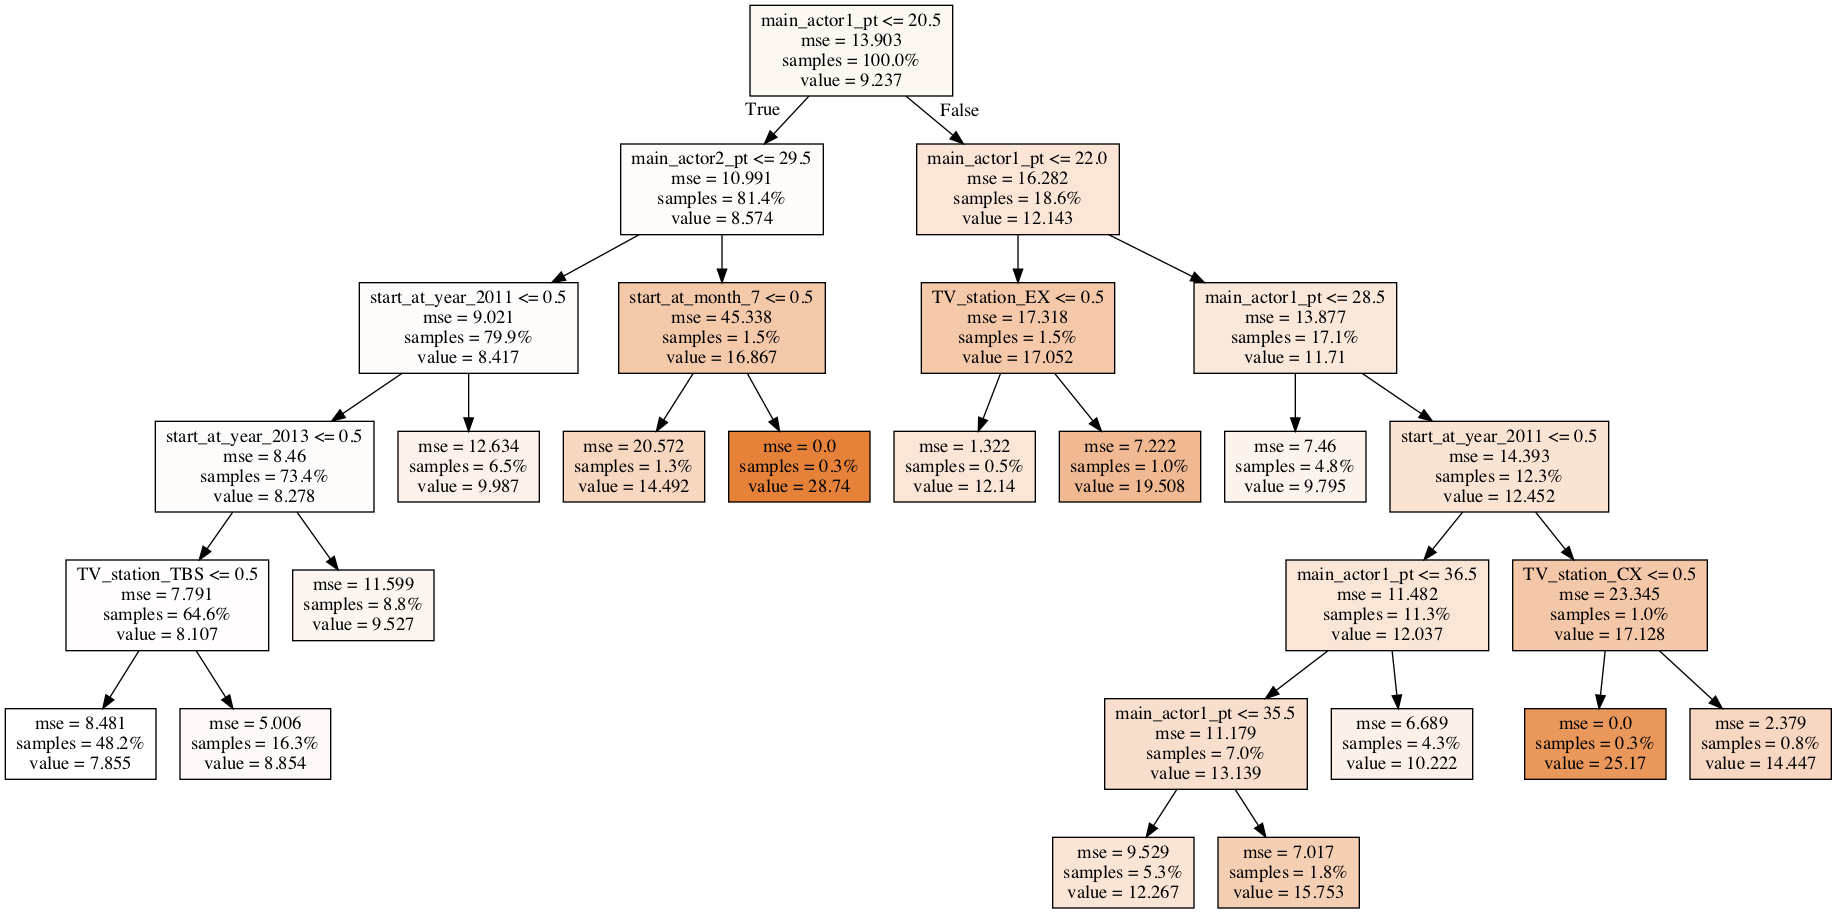

In [76]:
dot_data = tree.export_graphviz(
    clf,
    out_file=None,
    feature_names=X.columns,
    class_names="average",
    filled=True,
    proportion=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())